In [ ]:
# 캐글 설치
!pip install kaggle

In [ ]:
#캐글 json 파일 불러오기
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('user uploaded file"{name}"with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
user uploaded file"kaggle.json"with length 64 bytes


In [ ]:
# 캐글 폴더 생성
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!ls -1ha kaggle.json

! kaggle datasets download -d sadhliroomyprime/motorcycle-night-ride-semantic-segmentation

kaggle.json
100% 324M/325M [00:15<00:00, 25.0MB/s]
100% 325M/325M [00:15<00:00, 22.0MB/s]


In [ ]:
!unzip -q motorcycle-night-ride-semantic-segmentation.zip -d dataset_folder


In [ ]:
import os
import cv2
import tensorflow as tf
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

# 데이터 위치
DATA_PATH = '/content/dataset_folder/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/'
DATA_FOLDER = os.path.join(DATA_PATH, 'images/') ##이 부분에서 시간 오래 걸림

image_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(').png')]
mask_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('se.png')] # 친구가 이미지 세그멘테이션에는 fuse가 쓰이는게 맞다고 해서 수정

'''
#훈련 세트와 테스트 세트로 나누기 (20%를 테스트로 설정) - 코드 수정해서 넣어줘야하는데.... 아래에 추가
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
X_train, y_train = load_images_and_masks(train_files)
X_test, y_test = load_images_and_masks(test_files)
'''
X = []
y = []

for image_file in image_files[:]:
    # 이미지 파일 로드
    image_path = os.path.join(DATA_FOLDER, image_file)
    image = cv2.imread(image_path)
    X.append(image)

    # 해당 이미지에 대한 마스크 파일 찾기
    base_name = os.path.splitext(image_file)[0]  # 파일 이름에서 확장자 제거
    matching_mask_files = [mask_file for mask_file in mask_files if base_name in mask_file]
    if matching_mask_files:
        mask_file = matching_mask_files[0]  # 첫 번째 일치하는 마스크 파일 사용
        mask_path = os.path.join(DATA_FOLDER, mask_file)
        mask = cv2.imread(mask_path)
        y.append(mask)


X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
# test_size 비율이 높은건 낮추면 colab이 안돌아가서



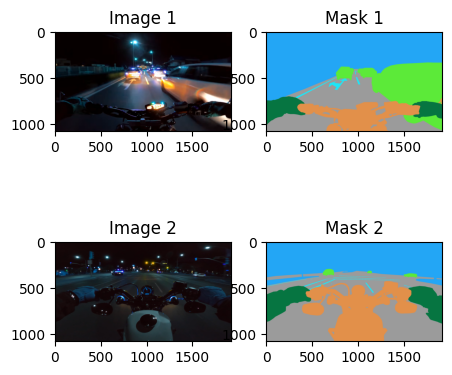

<Figure size 640x480 with 0 Axes>

In [ ]:
# 이미지 표시, 마스크 로딩 된건지 확인
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(5, 5))

axs[0, 0].imshow(X_train[0])
axs[0, 0].set_title("Image 1")
axs[0, 1].imshow(y_train[0])
axs[0, 1].set_title("Mask 1")
axs[1, 0].imshow(X_train[1])
axs[1, 0].set_title("Image 2")
axs[1, 1].imshow(y_train[1])
axs[1, 1].set_title("Mask 2")

plt.show()

plt.tight_layout() # 간격 넓어서 추가.


In [ ]:
# 데이터 증강
''' 원래 하려고 했던 방식
def augment1(image,label): # 밝기 조절
    delta = tf.random.uniform(shape=[], minval=-max_delta, maxval=max_delta)
    # 이미지의 밝기를 조절
    image = tf.image.adjust_brightness(image, delta)
    return image, label

def augment2(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전
    return image,label
'''


# 과제하면서 찾은 방법
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.9, 1.2])

# X_train 이미지를 로드하고 증강
num_augmented_images_per_original = 2
for image in X_train:
    image = np.expand_dims(image, axis=0)  # 4차원 배열로 확장 (처음에 오류 → ChatGPT 물어봄)
    augmented_images = datagen.flow(image)
    for i in range(num_augmented_images_per_original):
        augmented_image = augmented_images.next()
        augmented_image = augmented_image[0]


In [ ]:
print(X_train.shape)
# 200장 이었던거 같은데 2장 어디간거지? 해결

(59, 1080, 1920, 3)


In [ ]:
# Q. 사이즈 조절 vs 그대로 넣기
# A. 1920*1080 사이즈 그대로 넣고 돌려봤는데, 바로 멈춤 → 사이즈 조절 불가피

import tensorflow as tf
from tensorflow.keras.layers import Input, MaxPooling2D, concatenate, UpSampling2D, Dropout, Activation, BatchNormalization, Conv2D
from tensorflow.keras.models import Model

num_classes = 3

In [ ]:
# 참고했던 유튜브: https://www.youtube.com/watch?v=nCL7Y58jzH8&t=738s (파이토치)
def unet(input_size=(480, 272, 3), dropout_rate=0.1):
    inputs = Input(input_size)

    # Encoder 부분
    conv1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 중간층
    conv3 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)

    # Decoder 부분
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(up4)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(up5)
    conv5 = Activation('relu')(conv5)
    conv5 = BatchNormalization()(conv5)

    # 출력층
    outputs = Conv2D(3, 1, activation='softmax')(conv5) #교재 232p에 sigmoid가 낫다고 나와있는데, 인터넷은 softmax가 낫다고함...;;

    model = Model(inputs=inputs, outputs=outputs)

    return model

# U-Net 모델 생성
model = unet(input_size=(272, 480, 3))
# 가로세로 비율이 중요하나 싶어서 256,256 대신 사용

In [ ]:
# 사이즈 조절 - 리사이징 방법 (나중에 공부해볼 주제)
'''
이미지 크기를 리사이징할 때 원본 이미지와 목표 크기의 가로와 세로 비율이 다른 경우,
이미지를 리사이징하는 과정에서 비율을 유지하기 위해 몇 가지 방법을 사용할 수 있습니다.
일반적으로 다음 두 가지 방법을 사용합니다:

원본 비율을 유지한 채 리사이징
: 원본 이미지의 가로와 세로 비율을 계산하고, 이 비율을 유지한 채로 목표 크기에 맞게 이미지를 리사이징합니다.
이를 통해 원본 이미지의 종횡비가 유지됩니다. 일반적으로 빈 공간이 생길 수 있습니다.

가로 또는 세로 중 하나의 크기를 맞추고 다른 크기를 조정
: 가로와 세로 중 하나의 크기를 목표 크기에 맞추고, 다른 크기는 비율을 유지하면서 조정합니다.
이 방법은 원본 이미지의 한 쪽 크기를 맞추고 나머지 쪽을 잘라내는 경우입니다. 이렇게 하면 이미지가 잘릴 수 있습니다.
'''

target_size = (480, 272)
X_train_resized = []
y_train_resized = []


def resize_image(image):
    resized_image = cv2.resize(image, target_size)
    return resized_image

# X_train 이미지를 리사이징하고 리스트에 저장
for image in X_train:
    resized_image = resize_image(image)
    X_train_resized.append(resized_image)
for image in y_train:
    resized_image = resize_image(image)
    y_train_resized.append(resized_image)

y_train = np.array(y_train_resized)
# NumPy 배열로 변환
X_train_resized = np.array(X_train_resized)

# 결과 확인
print(X_train_resized.shape)
print(y_test.shape)

X_train = X_train_resized
#이렇게 그대로 바꿔주는게 하기에는 편한데, 보통 X_train_resized = [] 식으로 선언하고 그걸 넣어주는 이유는 데이터 저장과 관련있는건가?


(59, 272, 480, 3)
(139, 272, 480, 3)


In [ ]:
#클래스 수 확인
number_of_classes = y_train.shape[-1]
print(f"Number of classes: {number_of_classes}")


Number of classes: 3


In [ ]:
# 모델 확인
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 272, 480, 3)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 272, 480, 64)         1792      ['input_9[0][0]']             
                                                                                                  
 activation_30 (Activation)  (None, 272, 480, 64)         0         ['conv2d_42[0][0]']           
                                                                                                  
 batch_normalization_30 (Ba  (None, 272, 480, 64)         256       ['activation_30[0][0]']       
 tchNormalization)                                                                          

In [ ]:
def dice_score_loss_with_smooth(smooth=1.):
  def loss(y_true, y_pred):
    numerator = 2. * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return tf.reduce_mean(1 - numerator / denominator)
  return loss
# [출처] [Keras] Custom Loss Function 만들기|작성자 Paris Lee



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

X_train = X_train.astype('float32')
y_train = y_train.astype(np.float32) # 오류 나와서 바꾸라고 해서 바꾸긴 했는데, 이 부분 잘 모름




model.compile(optimizer=Adam(learning_rate=0.0004),loss=dice_score_loss_with_smooth(smooth=1.), metrics=['accuracy'])
# 교재 232p

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='try1', save_best_only=True)
    ]

epochs = 30
batch_size = 20

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)





Epoch 1/30
3/3 [==============================] - 7s 1s/step - loss: 0.1228 - accuracy: 0.5785
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.1187 - accuracy: 0.5868
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 0.1148 - accuracy: 0.5943
Epoch 4/30
3/3 [==============================] - 5s 1s/step - loss: 0.1122 - accuracy: 0.6006
Epoch 5/30
3/3 [==============================] - 5s 2s/step - loss: 0.1105 - accuracy: 0.5959
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 0.1108 - accuracy: 0.5971
Epoch 7/30
3/3 [==============================] - 5s 2s/step - loss: 0.1082 - accuracy: 0.6048
Epoch 8/30
3/3 [==============================] - 5s 2s/step - loss: 0.1093 - accuracy: 0.6053
Epoch 9/30
3/3 [==============================] - 5s 1s/step - loss: 0.1079 - accuracy: 0.6042
Epoch 10/30
3/3 [==============================] - 4s 1s/step - loss: 0.1068 - accuracy: 0.6045
Epoch 11/30
3/3 [==============================] 

In [ ]:
import cv2
# 모델의 입력 크기
input_size = (480, 270)
X_test_resized = [cv2.resize(image, (input_size[1], input_size[0])) for image in X_test]
y_test_resized = [cv2.resize(mask, (input_size[1], input_size[0])) for mask in y_test]


from tensorflow.keras.metrics import MeanIoU

# 이미지 분할에서 평가는 accuracy가 아니라 IoU나 Dice Coefficient를 사용함
def calculate_iou(y_true, y_pred, num_classes):
    iou_calculator = MeanIoU(num_classes=num_classes)
    iou_calculator.update_state(y_true, y_pred)
    return iou_calculator.result().numpy()
def preprocess_masks(pred_masks, true_masks, threshold=0.5):
    pred_masks = pred_masks > threshold
    true_masks = true_masks > threshold
    return pred_masks, true_masks

def evaluate_model(model, X_test, y_test, num_classes):
    # 모델의 예측 결과를 얻습니다.
    y_pred = model.predict(X_test)

    # 예측 결과와 실제 값을 전처리합니다.
    y_pred_processed, y_test_processed = preprocess_masks(y_pred, y_test)

    # IoU를 계산합니다.
    iou = calculate_iou(y_test_processed, y_pred_processed, num_classes)

    return iou

# 모델 평가
iou_score = evaluate_model(model, y_test, y_test, num_classes=3)
print("IoU Score:", iou_score)

5/5 [==============================] - 2s 463ms/step
IoU Score: 0.25000042


1/1 [==============================] - 0s 194ms/step


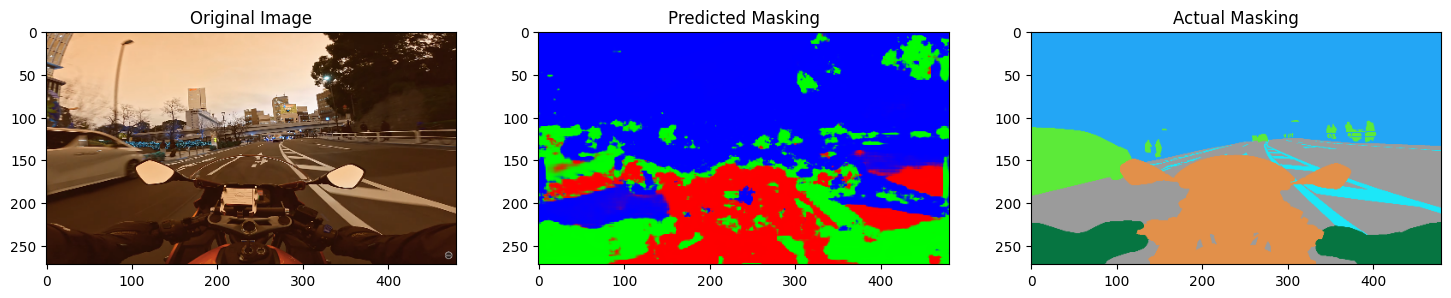

In [ ]:
import matplotlib.pyplot as plt

# 예측 수행
# 이 예제에서는 테스트 데이터셋의 첫 번째 이미지에 대한 예측을 수행하고 있습니다.
predicted_mask = model.predict(X_test[0:1])
predicted_mask = predicted_mask[0]  # 첫 번째 예측 결과를 가져옵니다.

# 원본 이미지, 예측 마스크, 실제 마스크를 시각화
plt.figure(figsize=(18, 6))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(X_test[0])

# 모델이 예측한 마스킹
plt.subplot(1, 3, 2)
plt.title('Predicted Masking')
plt.imshow(predicted_mask)

# 실제 마스킹 이미지
plt.subplot(1, 3, 3)
plt.title('Actual Masking')
plt.imshow(y_test[0])

plt.show()